<a href="https://colab.research.google.com/github/farihahahaa/farihahahaa/blob/main/Climate_and_Health_Records_Pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load imports

In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
import seaborn as sns
import zipfile

import torch

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers.legacy import Adam
# Modelling
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
#https://www.datacamp.com/tutorial/understanding-logistic-regression-python
from sklearn.ensemble import RandomForestClassifier
#https://www.datacamp.com/tutorial/random-forests-classifier-python
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

ModuleNotFoundError: No module named 'statsmodels'

Import drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
filepath_research1 = "/content/drive/MyDrive/Climformatics/research.csv"
research1 = pd.read_csv(filepath_research1, index_col=0)

#research 2 is small counties
# drive.mount("/content/drive", force_remount=True)
# filepath_research2 = "/content/drive/MyDrive/Climformatics/research2.csv"
# research2 = pd.read_csv(filepath_research2, index_col=0)

In [ ]:
# num_unique_values = research2.index.nunique()
# num_unique_values

#15 counties exlcuded out of 58 so 43 models

Import temperature data

In [ ]:
def find_header_start(file_path, header_start):
    """
    Finds the line number where the actual header (column names) starts.
    """
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if line.strip().startswith(header_start):
                return i
    return None

def load_and_process(file_path, header_start):
    header_line = find_header_start(file_path, header_start)
    if header_line is not None:
        data = pd.read_csv(file_path, skiprows=header_line)
        # Delete the last 24 rows from the data
        data = data[:-24] if len(data) > 24 else data  # Ensures we don't try to delete rows if there are fewer than 24

        data['DATETIME'] = pd.to_datetime(data['YEAR'].astype(str) + '-' +
                                          data['MO'].astype(str).str.zfill(2) + '-' +
                                          data['DY'].astype(str).str.zfill(2) + ' ' +
                                          data['HR'].astype(str).str.zfill(2) + ':00:00')
        data.set_index('DATETIME', inplace=True)
        data.drop(columns=['YEAR', 'MO', 'DY', 'HR'], inplace=True)

        # Replace -999 with NaN for consistent processing
        data.replace(-999, np.nan, inplace=True)

        # Compute rolling means for each column, replacing NaN values
        for column in data.columns:
            rolling_means = data[column].replace(np.nan, method='ffill').rolling(window=12, min_periods=1).mean()
            data[column] = data[column].fillna(rolling_means)

        return data
    else:
        raise ValueError("Header start not found in the file.")


file_path = "/content/drive/My Drive/Climformatics/counties/counties2/San francisco.csv"
header_start = "YEAR,MO,DY,HR,T2M,T2MWET,RH2M,WS10M,ALLSKY_SFC_SW_DWN"
#T2M,RH2M,WS10M,ALLSKY_SFC_SW_DWN


# Load the data
weather_data = load_and_process(file_path, header_start)

# Display the first few rows to confirm successful loading and processing
print(weather_data.head())

                       T2M  T2MWET   RH2M  WS10M  ALLSKY_SFC_SW_DWN
DATETIME                                                           
2014-04-05 16:00:00  15.26   12.26  67.31   6.19               1.41
2014-04-05 17:00:00  13.84   11.74  75.69   5.48               0.60
2014-04-05 18:00:00  11.92   10.95  87.81   4.47               0.06
2014-04-05 19:00:00  10.93   10.55  94.94   4.09               0.00
2014-04-05 20:00:00  10.59   10.44  97.94   3.91               0.00


In [ ]:
weather_data = weather_data[['T2MWET']]

Look at data types of two data sets to combine them

In [ ]:
# Convert the 'date' column to datetime format
research1['serv_dt'] = pd.to_datetime(research1['serv_dt'], format='%m/%d/%Y')

# Display the DataFrame
#print(research1)
research1 = research1.loc[research1.index == 'San Francisco']

In [ ]:
research1.tail()

,serv_dt,ED Visit,ED Admit,Inpatient Only
hplcnty,,,,
San Francisco,2022-09-29,NaN,NaN,1.0
San Francisco,2022-09-30,1.0,NaN,NaN
San Francisco,2022-10-07,1.0,NaN,NaN
San Francisco,2022-10-10,1.0,NaN,NaN
San Francisco,2022-10-19,NaN,1.0,NaN


In [ ]:
#research1_ala.set_index('serv_dt')
#research1_ala.index.dtype
# research1_ala = research1_ala.set_index('datetime')
# research1_ala.index.inferred_type == "datetime"

In [ ]:
weather_data.head(9)
idx = weather_data.groupby(weather_data.index.date)['T2MWET'].idxmax()

# Filter the DataFrame to keep only the max temperature rows for each day
result_df_weather = weather_data.loc[idx]

# Display the result
result_df_weather.index = result_df_weather.index.normalize()
result_df_weather.head()

,T2MWET
DATETIME,
2014-04-05,12.26
2014-04-06,16.12
2014-04-07,17.89
2014-04-08,17.99
2014-04-09,14.81


In [ ]:
result_df_weather.index.inferred_type == "datetime64"

True

In [ ]:
# research1_ala = research1_ala.set_index('Datetime')
# research1_ala.index.inferred_type == "datetime64"

In [ ]:
#merged_df = pd.merge(result_df_weather_al, research1_ala, left_index=True, right_index=True)
merged_df = pd.merge(result_df_weather, research1, left_index=True, right_on='serv_dt')

merged_df.head()

,T2MWET,serv_dt,ED Visit,ED Admit,Inpatient Only
hplcnty,,,,,
San Francisco,16.30,2016-03-26,1.0,NaN,NaN
San Francisco,19.85,2016-04-06,3.0,1.0,NaN
San Francisco,15.62,2016-04-16,1.0,NaN,NaN
San Francisco,17.72,2016-04-17,1.0,NaN,NaN
San Francisco,17.69,2016-05-30,1.0,NaN,NaN


In [ ]:
merged_df = merged_df.rename({'T2MWET': 'temp', 'serv_dt': 'date', 'ED Visit': 'ed_visit'}, axis='columns')
merged_df = merged_df[['temp', 'date', 'ed_visit']]
merged_df = merged_df.dropna()
len(merged_df) #373 with null
merged_df.isnull().any(axis=0)

temp        False
date        False
ed_visit    False
dtype: bool

In [ ]:
merged_df.head()

,temp,date,ed_visit
hplcnty,,,
San Francisco,16.30,2016-03-26,1.0
San Francisco,19.85,2016-04-06,3.0
San Francisco,15.62,2016-04-16,1.0
San Francisco,17.72,2016-04-17,1.0
San Francisco,17.69,2016-05-30,1.0


In [ ]:
merged_df.isnull().any(axis=0)
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%Y/%m/%d')
#len(merged_df)

In [ ]:
# merged_df['Day'] = merged_df.index.day
# merged_df['Month'] = merged_df.index.month
# merged_df['Year'] = merged_df.index.year
# merged_df['DayOfWeek'] = merged_df.index.dayofweek

# # Define features and target variable
# features = ['temp', 'Day', 'Month', 'Year']
# #,'DayOfWeek'
# target = 'ed_visit'

# X = merged_df[features]
# y = merged_df[target]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# Convert datetime to ordinal
merged_df['date'] = merged_df['date'].map(pd.Timestamp.toordinal)

# Normalize the features
scaler = MinMaxScaler()
merged_df[['date', 'temp']] = scaler.fit_transform(merged_df[['date', 'temp']])

# Define features and target
features = merged_df[['date', 'temp']]
target = merged_df['ed_visit']

# Define sequence length
sequence_length = 5

# Generate time series sequences
generator = TimeseriesGenerator(features, target, length=10, batch_size=1)

In [ ]:
len(generator)

93

In [ ]:
# # from keras.optimizers import Adam, SGD, RMSprop, Adagrad
# from sklearn.metrics import mean_squared_error

# # # List of optimizers to try
# # optimizers = {
# #     'SGD': SGD(learning_rate=0.01),
# #     'RMSprop': RMSprop(learning_rate=0.001),
# #     'Adam': Adam(learning_rate=0.001),
# #     'Adagrad': Adagrad(learning_rate=0.01)
# # }

# activations = ['relu', 'tanh', 'sigmoid', 'linear']

# results = {}

# for act in activations:
#     print(f"Testing model with {act} activation...")
#     # Build the model with the current optimizer
#     model = Sequential()
#     #input_shape=(sequence_length, 2),
#     model.add(LSTM(10, activation=act, input_shape=(sequence_length, features.shape[1])))
#     model.add(Dense(1))

#     model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#     # Fit model
#     model.fit(generator, epochs=5)  # Use fewer epochs for quick iteration

#     # Evaluate model
#     predictions = model.predict(generator)
#     actuals = np.array([y for x, y in generator])
#     # 'mae' in history.history
#     mse = mean_squared_error(predictions, actuals)
#     #generator.targets, predictions
#     rmse = np.sqrt(mse)

#     # Store results
#     results[name] = rmse
#     print(f"{name} RMSE: {rmse}")

# # # Determine the best optimizer
# # best_opt = min(results, key=results.get)
# # print(f"Best optimizer: {best_opt} with RMSE: {results[best_opt]}")
# best_activation = min(results, key=results.get)
# print(f"Best activation function: {best_activation} with RMSE: {results[best_activation]}")

In [ ]:
# Define the model
model = Sequential()
#'relu'
#input_shape=(sequence_length, 2)
#input_shape=(sequence_length, features.shape[1])
model.add(LSTM(6, activation='relu', input_shape=(sequence_length, features.shape[1]), dropout=0.3))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#tanh was best

In [ ]:
# Fit the model
history = model.fit(generator, epochs=15)


Epoch 1/15
93/93 [==============================] - 2s 6ms/step - loss: 48.0735 - accuracy: 0.2473
Epoch 2/15
93/93 [==============================] - 1s 6ms/step - loss: 45.0185 - accuracy: 0.6452
Epoch 3/15
93/93 [==============================] - 1s 6ms/step - loss: 44.3700 - accuracy: 0.6667
Epoch 4/15
93/93 [==============================] - 1s 6ms/step - loss: 43.1940 - accuracy: 0.6667
Epoch 5/15
93/93 [==============================] - 1s 7ms/step - loss: 44.2479 - accuracy: 0.6667
Epoch 6/15
93/93 [==============================] - 1s 6ms/step - loss: 42.7090 - accuracy: 0.6667
Epoch 7/15
93/93 [==============================] - 1s 7ms/step - loss: 43.2974 - accuracy: 0.6667
Epoch 8/15
93/93 [==============================] - 1s 9ms/step - loss: 42.0119 - accuracy: 0.6667
Epoch 9/15
93/93 [==============================] - 1s 9ms/step - loss: 42.1625 - accuracy: 0.6667
Epoch 10/15
93/93 [==============================] - 1s 6ms/step - loss: 42.4881 - accuracy: 0.6667
Epoch 11/

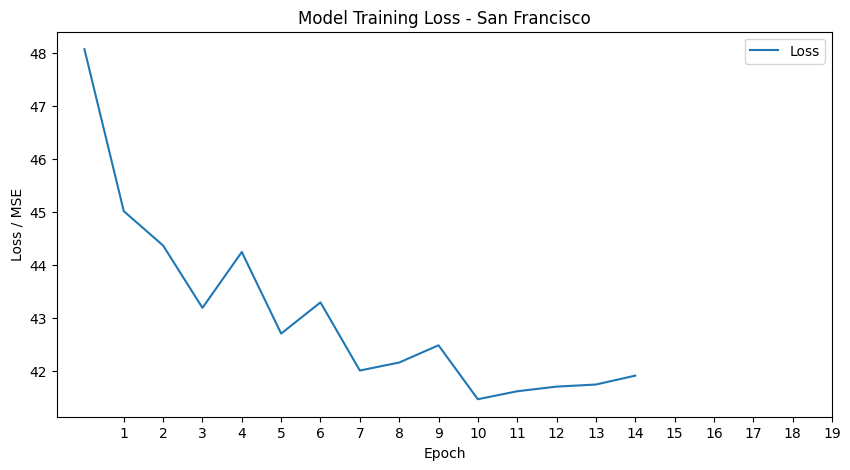

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
if 'mse' in history.history:
    plt.plot(history.history['mse'], label='Mean Squared Error')
plt.title('Model Training Loss - San Francisco')
plt.ylabel('Loss / MSE')
plt.xlabel('Epoch')
plt.xticks(range(1,20))
plt.legend(loc='upper right')
plt.show()


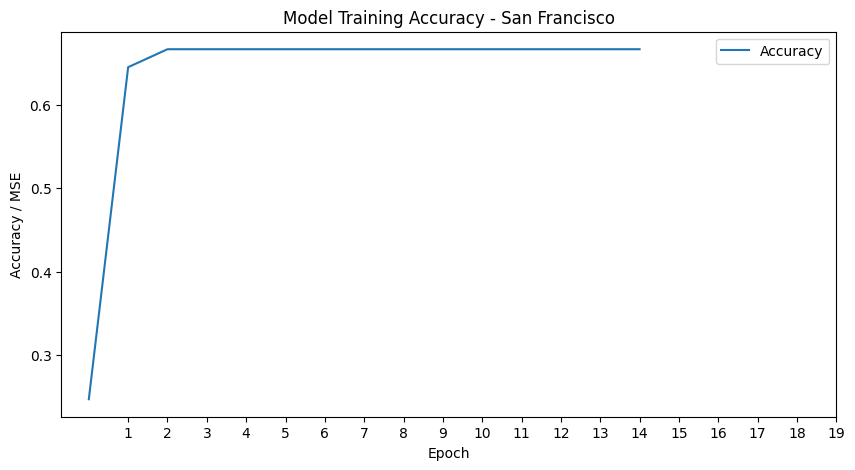

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Accuracy')
if 'mse' in history.history:
    plt.plot(history.history['mse'], label='Mean Squared Error')
plt.title('Model Training Accuracy - San Francisco')
plt.ylabel('Accuracy / MSE')
plt.xlabel('Epoch')
plt.xticks(range(1,20))
plt.legend(loc='upper right')
plt.show()

In [ ]:
predictions = model.predict(generator)

93/93 [==============================] - 1s 5ms/step


In [ ]:
merged_df['ed_visit']
ed_visits = merged_df.to_numpy()[:, 2]
ed_visits[:3]

array([1., 3., 1.])

In [ ]:
def make_list_of_lists(list1):
  """Converts a list of items into a list of lists, where each item is its own list.

  Args:
    list1: A list of items.

  Returns:
    A list of lists, where each item is its own list.
  """

  list_of_lists = []
  for item in list1:
    list_of_lists.append([item])
  return list_of_lists


list_ed_visits = make_list_of_lists(ed_visits)

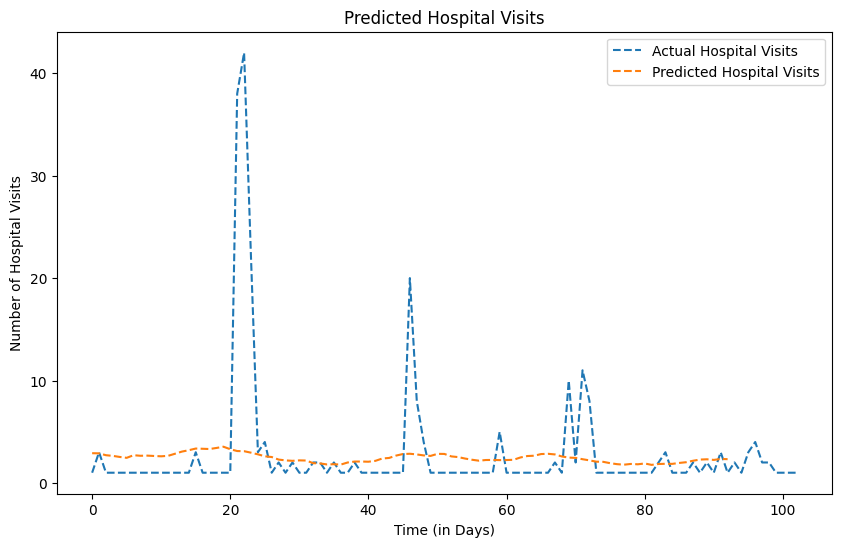

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(list_ed_visits, label='Actual Hospital Visits', linestyle='--')
plt.plot(predictions, label='Predicted Hospital Visits', linestyle='--')
plt.title('Predicted Hospital Visits')
plt.xlabel('Time (in Days)')
plt.ylabel('Number of Hospital Visits')
plt.legend()
plt.show()

In [ ]:
dates = pd.date_range(start='2023-01-01', periods=len(list_ed_visits), freq='D')
len(predictions)

93

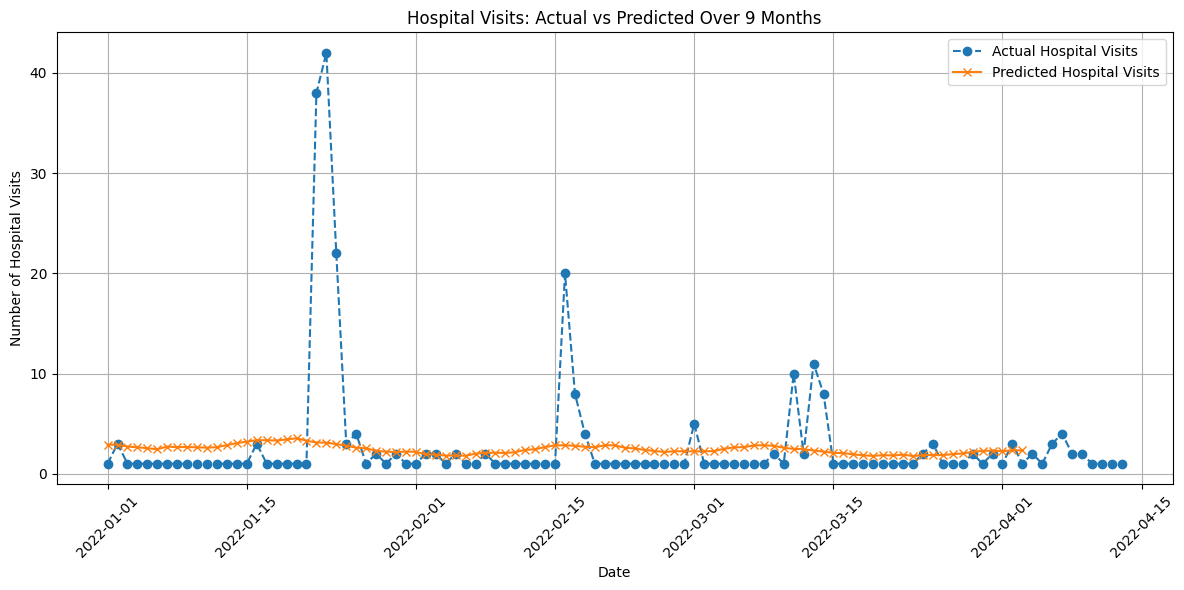

In [ ]:
dates = pd.date_range(start='2022-01-01', periods=len(list_ed_visits), freq='D')

plt.figure(figsize=(12, 6))
plt.plot(dates, list_ed_visits, label='Actual Hospital Visits', linestyle='--', marker='o')
plt.plot(dates[:93], predictions, label='Predicted Hospital Visits', linestyle='-', marker='x')
plt.title('Hospital Visits: Actual vs Predicted Over 9 Months')
plt.xlabel('Date')
plt.ylabel('Number of Hospital Visits')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [ ]:
merged_df.dtypes
merged_df['date'] = pd.to_datetime(merged_df['date'], utc=True)
merged_df.dtypes

temp                    float64
date        datetime64[ns, UTC]
ed_visit                float64
dtype: object

Mean Squared Error: 12.229127116402115


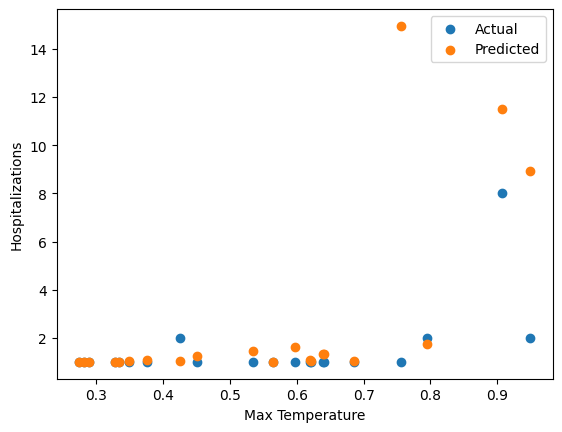

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#merged_df['date'] = pd.to_datetime(merged_df['date'], utc=True)

merged_df.set_index('date', inplace=True)

# Feature engineering: extract day of week, month, etc. if needed
merged_df['Day'] = merged_df.index.day
merged_df['Month'] = merged_df.index.month
merged_df['Year'] = merged_df.index.year
merged_df['DayOfWeek'] = merged_df.index.dayofweek

# Define features and target variable
features = ['temp', 'Day', 'Month', 'Year','DayOfWeek']
#,'DayOfWeek'
target = 'ed_visit'

X = merged_df[features]
y = merged_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Plot predicted vs. actual values
plt.scatter(X_test['temp'], y_test, label='Actual')
plt.scatter(X_test['temp'], predictions, label='Predicted')
plt.xlabel('Max Temperature')
plt.ylabel('Hospitalizations')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(merged_df[['temp', 'ed_visit']])

# Function to create a dataset as required by LSTM (sequences)
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]  # Only temperature data
        X.append(a)
        Y.append(data[i + look_back, 1])  # Hospital visits data
    return np.array(X), np.array(Y)

# Generate dataset for training
look_back = 1  # Number of previous time steps to consider
X, Y = create_dataset(scaled, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [ ]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(1, look_back), kernel_regularizer='l2'),
#     Dropout(0.2),
#     LSTM(50, kernel_regularizer='l2'),
#     Dropout(0.2),
#     Dense(1)
# ])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#model.fit(generator, epochs=10)


In [ ]:
model = Sequential()
model.add(LSTM(35,input_shape=(35, 51)))  #35 days, 51 features
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
## Create and fit the LSTM network

model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
#, kernel_regularizer='l2')
#return_sequences=True, kernel_regularizer='l2'
#model.add(Dropout(0.2))
# model.add(LSTM(50, kernel_regularizer='l2'))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#model.fit(generator, epochs=10)

In [ ]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(np.concatenate((trainX[:,:,0], trainPredict), axis=1))[:,1]
trainY = scaler.inverse_transform(np.concatenate((trainX[:,:,0], trainY.reshape(-1,1)), axis=1))[:,1]
testPredict = scaler.inverse_transform(np.concatenate((testX[:,:,0], testPredict), axis=1))[:,1]
testY = scaler.inverse_transform(np.concatenate((testX[:,:,0], testY.reshape(-1,1)), axis=1))[:,1]

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


3/3 [==============================] - 0s 4ms/step
Train Score: 3.84 RMSE
Test Score: 2.73 RMSE


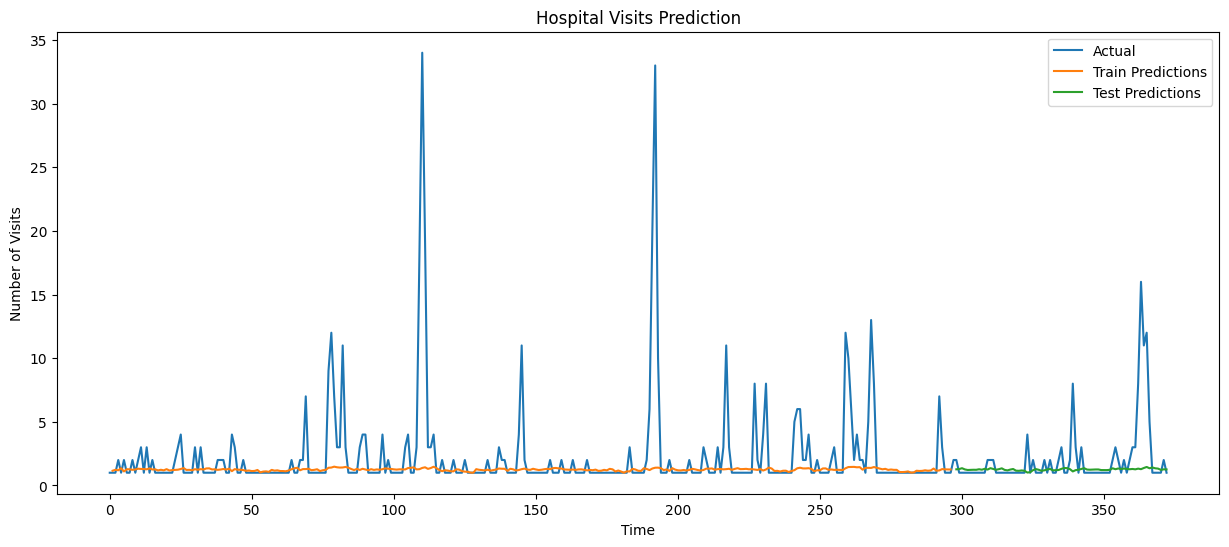

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df, trainPredict, and testPredict have been defined and are properly sized

# Initialize empty arrays for plotting with NaN values
trainPredictPlot = np.empty_like(merged_df['ed_visit'])
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(merged_df['ed_visit'])
testPredictPlot[:] = np.nan

# Populate the plotting arrays with predictions in their respective positions
trainPredictPlot[look_back:look_back + len(trainPredict)] = trainPredict
testPredictPlot[len(trainPredict) + look_back * 2:len(trainPredict) + look_back * 2 + len(testPredict)] = testPredict

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(merged_df['ed_visit'].reset_index(drop=True), label='Actual')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.title('Hospital Visits Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Visits')
plt.legend()
plt.show()


In [ ]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=30, batch_size=1, verbose=2)

Epoch 1/20
296/296 - 2s - loss: 12.3766 - accuracy: 0.6014 - val_loss: 6.1504 - val_accuracy: 0.6133 - 2s/epoch - 6ms/step
Epoch 2/20
296/296 - 2s - loss: 12.4006 - accuracy: 0.6047 - val_loss: 6.1437 - val_accuracy: 0.6133 - 2s/epoch - 5ms/step
Epoch 3/20
296/296 - 2s - loss: 12.3687 - accuracy: 0.6149 - val_loss: 6.0889 - val_accuracy: 0.6133 - 2s/epoch - 8ms/step
Epoch 4/20
296/296 - 2s - loss: 12.3703 - accuracy: 0.6115 - val_loss: 6.0779 - val_accuracy: 0.6133 - 2s/epoch - 7ms/step
Epoch 5/20
296/296 - 2s - loss: 12.4054 - accuracy: 0.6081 - val_loss: 6.0620 - val_accuracy: 0.6133 - 2s/epoch - 5ms/step
Epoch 6/20
296/296 - 1s - loss: 12.3587 - accuracy: 0.6115 - val_loss: 6.0252 - val_accuracy: 0.6133 - 1s/epoch - 4ms/step
Epoch 7/20
296/296 - 2s - loss: 12.3422 - accuracy: 0.6115 - val_loss: 6.0055 - val_accuracy: 0.6133 - 2s/epoch - 7ms/step
Epoch 8/20
296/296 - 1s - loss: 12.3745 - accuracy: 0.6115 - val_loss: 6.0534 - val_accuracy: 0.6133 - 1s/epoch - 4ms/step
Epoch 9/20
296/2

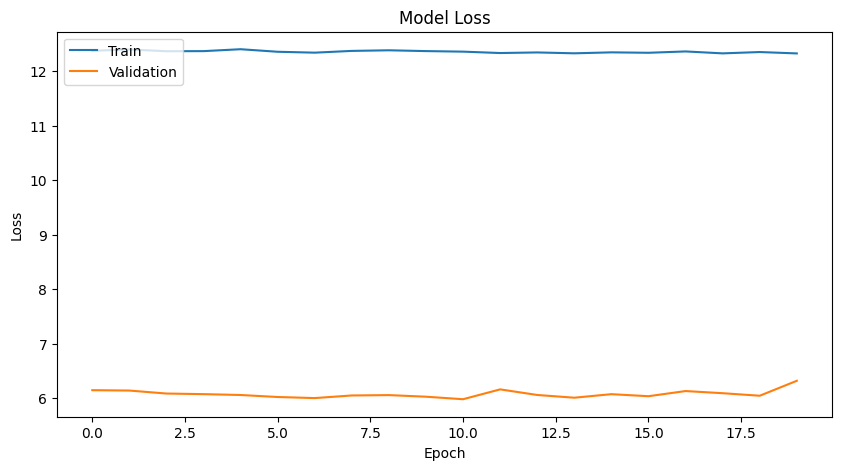

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


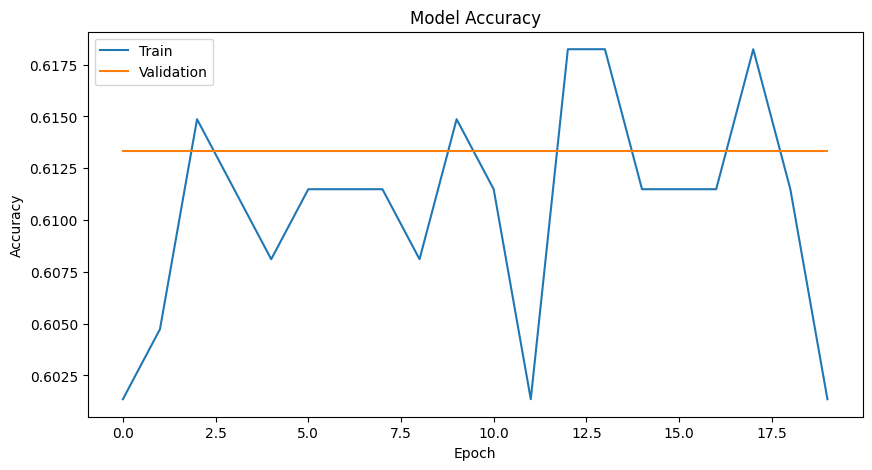

In [ ]:
# Check if 'accuracy' is in the history
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [ ]:
#stop here

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `predictions` are your model's output and `target` is your actual data
# We need to align the target data with your predictions (target data should be shifted to match the prediction start)
actual = np.array(target[sequence_length:])

# Calculate MSE and MAE
mse = mean_squared_error(filtered_actual, predictions)
mae = mean_absolute_error(filtered_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

ValueError: Found input variables with inconsistent numbers of samples: [425, 75]